In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import ast
from itertools import zip_longest
import glob

import warnings
warnings.filterwarnings('ignore')

In [125]:
# target = "Lehne"
target = "Delatorre"

In [126]:
def get_zipped_average(lists):
    zipped_lists = zip_longest(*lists, fillvalue=None)
    averages = [
        sum(filter(None.__ne__, group)) / max(1, len(list(filter(None.__ne__, group))))
        for group in zipped_lists
    ]
    return averages

def get_llm_ratings(llm_rating_sources: list[str]) -> list[float]:
    """
    Get the average llm rating for a given source.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        List of all llm ratings for the given source.
        If multiple sources are given return the average rating across all sources.
    """
    all_source_ratings = []

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        source_ratings = []
        
        # Traverse through the directory to find CSV files
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".csv"):
                    # Read the CSV file
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path)
                    
                    # Assuming the response column contains the dictionary of ratings as string
                    if 'response' in df.columns:
                        model_ratings = []
                        for response in df['response']:
                            response_dict = ast.literal_eval(response)
                            ratings = response_dict.values()
                            model_ratings.append(ratings)
                        source_ratings = get_zipped_average(model_ratings)
        
        if source_ratings:
            all_source_ratings.append(source_ratings)

    llm_ratings = get_zipped_average(all_source_ratings)
    return llm_ratings

def get_per_model_ratings(llm_rating_sources: list[str]) -> dict[str, list[float]]:
    """
    Get the llm ratings from all sources.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        Dict of all llm ratings from all sources.
        Keyed by model name to list of scores.
    """
    all_ratings = {}

    experiments = ["e1", "e2", "e3"]
    model_names = ['deepseek-ai_DeepSeek-V3', 'google_gemma-2-27b-it', 'google_gemma-2-9b-it', 'meta-llama_Llama-2-7b-chat-hf', 'meta-llama_Llama-3-70b-chat-hf', 'meta-llama_Llama-3-8b-chat-hf', 'microsoft_WizardLM-2-8x22B', 'mistralai_Mistral-7B-Instruct-v0.3', 'mistralai_Mixtral-8x7B-Instruct-v0.1', 'Qwen_Qwen2-72B-Instruct']
    shortened_model_names = ["DS-V3", "G-27B", "G-9B", 'L2-7B', 'L3-70B', 'L3-8B', 'W-22B', 'M-7B', 'Mx-7B', 'Q-72B']

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"

        for experiment in experiments:
            for i, model in enumerate(model_names):
                csv_path = os.path.join(source, experiment, model)
                csv_path = os.path.join(csv_path, os.listdir(csv_path)[0], "results.csv")

                # Read the CSV file
                ratings = []
                df = pd.read_csv(csv_path)
                if 'response' in df.columns:
                    for response in df['response']:
                        response_dict = ast.literal_eval(response)
                        ratings = list(response_dict.values())

                shortened_model_name = shortened_model_names[i]
                if shortened_model_name not in all_ratings:
                    all_ratings[shortened_model_name] = []
                all_ratings[shortened_model_name].append(ratings)

    for shortened_model_name, ratings in all_ratings.items():
        all_ratings[shortened_model_name] = get_zipped_average(ratings)

    return all_ratings

def get_adversarial_ratings(llm_adversarial_sources: list[str]) -> dict[str, list[float]]:
    """
    Get the llm ratings from all adversarial sources.
    Args:
        llm_adversarial_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        Dict of all llm ratings from all sources.
        Keyed by adversarial attack name to list of scores.
    """
    all_ratings = {}

    attacks = ["antonym_replacement", "caesar_cipher", "change_character_names", "context_removal", "control", "distraction_insertion", "introduce_typos", "shuffle_sentences", "swap_words", "synonym_replacement", "word_swap_embedding", "word_swap_homoglyph"]
    experiments = ["e0", "e1", "e2"]
    model_names = ['deepseek-ai_DeepSeek-V3', 'google_gemma-2-27b-it', 'google_gemma-2-9b-it', 'meta-llama_Llama-2-7b-chat-hf', 'meta-llama_Llama-3-70b-chat-hf', 'meta-llama_Llama-3-8b-chat-hf', 'microsoft_WizardLM-2-8x22B', 'mistralai_Mistral-7B-Instruct-v0.3', 'mistralai_Mixtral-8x7B-Instruct-v0.1', 'Qwen_Qwen2-72B-Instruct']

    for source in llm_adversarial_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"

        for attack in attacks:

            if attack not in all_ratings:
                all_ratings[attack] = []

            for experiment in experiments:
                for i, model in enumerate(model_names):
                    csv_path = os.path.join(source, attack, experiment, model)
                    csv_path = os.path.join(csv_path, os.listdir(csv_path)[0], "results.csv")

                    # Read the CSV file
                    ratings = []
                    df = pd.read_csv(csv_path)
                    if 'response' in df.columns:
                        for response in df['response']:
                            response_dict = ast.literal_eval(response)
                            ratings = list(response_dict.values())

                    all_ratings[attack].append(ratings)

    for attack, ratings in all_ratings.items():
        all_ratings[attack] = get_zipped_average(ratings)

    return all_ratings

In [127]:
llm_rating_sources = None
llm_adversarial_sources = None
if target == "Lehne":
    llm_rating_sources = ["lehne_experiment/final/"]
    llm_adversarial_sources = ["lehne_experiment/adversarial/"]
elif target == "Delatorre":
    llm_rating_sources = ["delatorre_experiment/final/"]
    llm_adversarial_sources = ["delatorre_experiment/adversarial/"]

llm_ratings = get_llm_ratings(llm_rating_sources)
llm_ratings_by_model = get_per_model_ratings(llm_rating_sources)
llm_ratings_adversarial = get_adversarial_ratings(llm_adversarial_sources)

In [128]:
lehne = [5.565217391, 5, 4.826086957, 5.739130435, 5.52173913, 6.826086957, 7.304347826, 5.434782609, 6.391304348, 7.47826087, 7.043478261, 5.869565217, 6.739130435, 6.956521739, 6.47826087, 5.956521739, 4.652173913, 4.260869565, 5.173913043, 4.086956522, 4.173913043, 4.304347826, 5, 4.043478261, 4.217391304, 4.434782609, 5.347826087, 6.217391304, 5.434782609, 4.782608696, 6.173913043, 5.956521739, 6.47826087, 5, 4.739130435, 5.173913043, 6.304347826, 6.434782609, 5.260869565, 5.304347826, 5.956521739, 4.304347826, 5.260869565, 4.391304348, 4.956521739, 5.695652174, 5.043478261, 5.826086957, 5.043478261, 4.913043478, 5.217391304, 6.217391304, 6.391304348, 6.52173913, 7.217391304, 6.565217391, 5.52173913, 4.347826087, 3.869565217, 7, 7.565217391, 6.52173913, 6.260869565, 6.043478261, 4.913043478]

delatorre = [3.34, 3.725, 3.705, 3.89, 4.08, 5.02, 4.87, 4.81, 5.84, 5.77, 6.44, 4.685]

In [129]:
human_ratings = None
if target == "Lehne":
    human_ratings = lehne
elif target == "Delatorre":
    human_ratings = delatorre

In [130]:
figsize = None
fontsize = None
if target == "Lehne":
    figsize = (40, 11)
    fontsize = 23
elif target == "Delatorre":
    figsize = (16, 11)
    fontsize = 14

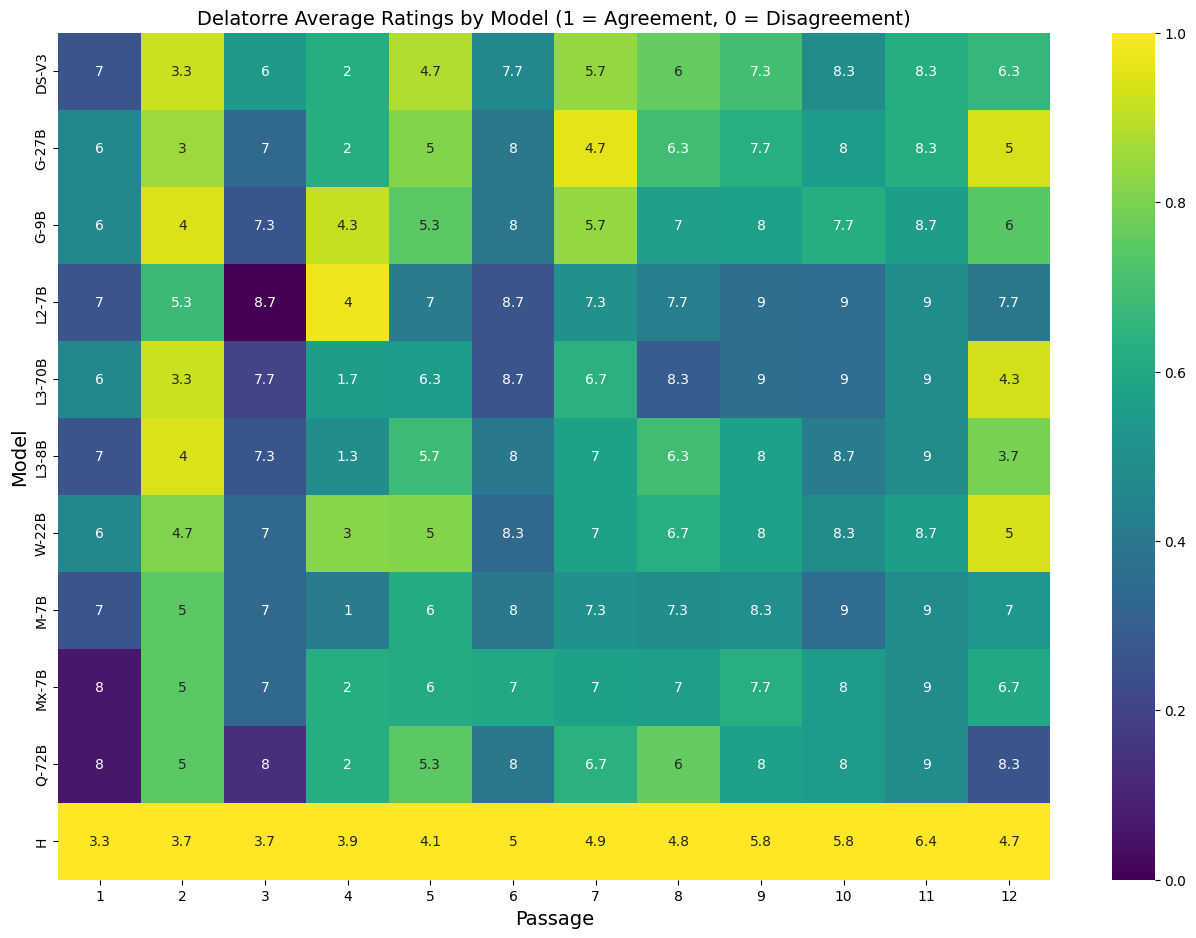

In [131]:
model_names = list(llm_ratings_by_model.keys()) + ["H"]
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings - human_ratings))
agreement_matrix = 1 - (np.abs(llm_ratings - human_ratings) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="viridis", cbar=True, linewidths=0, xticklabels=range(1, llm_ratings.shape[1] + 1), yticklabels=model_names)

plt.title(f"{target} Average Ratings by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Model", fontsize=fontsize)
plt.show()

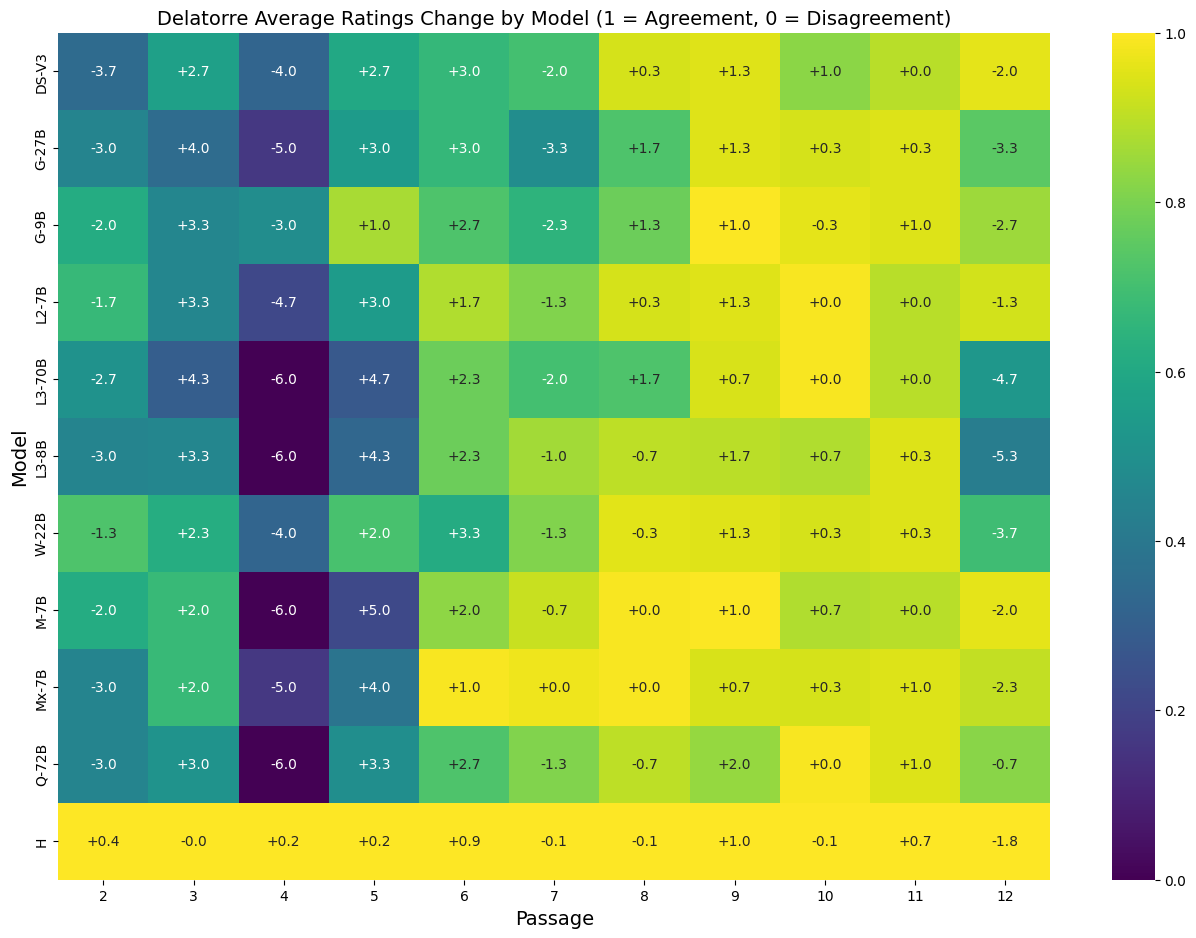

In [132]:
def fmt_func(value):
    return f"+{value:.1f}" if value >= 0 else f"{value:.1f}"

model_names = list(llm_ratings_by_model.keys()) + ["H"]
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

annot_fmt = np.vectorize(fmt_func)(llm_ratings_change)

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change - human_ratings_change))
agreement_matrix = 1 - (np.abs(llm_ratings_change - human_ratings_change) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=annot_fmt, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(2, llm_ratings_change.shape[1] + 2), yticklabels=model_names, fmt="")

plt.title(f"{target} Average Ratings Change by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Model", fontsize=fontsize)
plt.show()

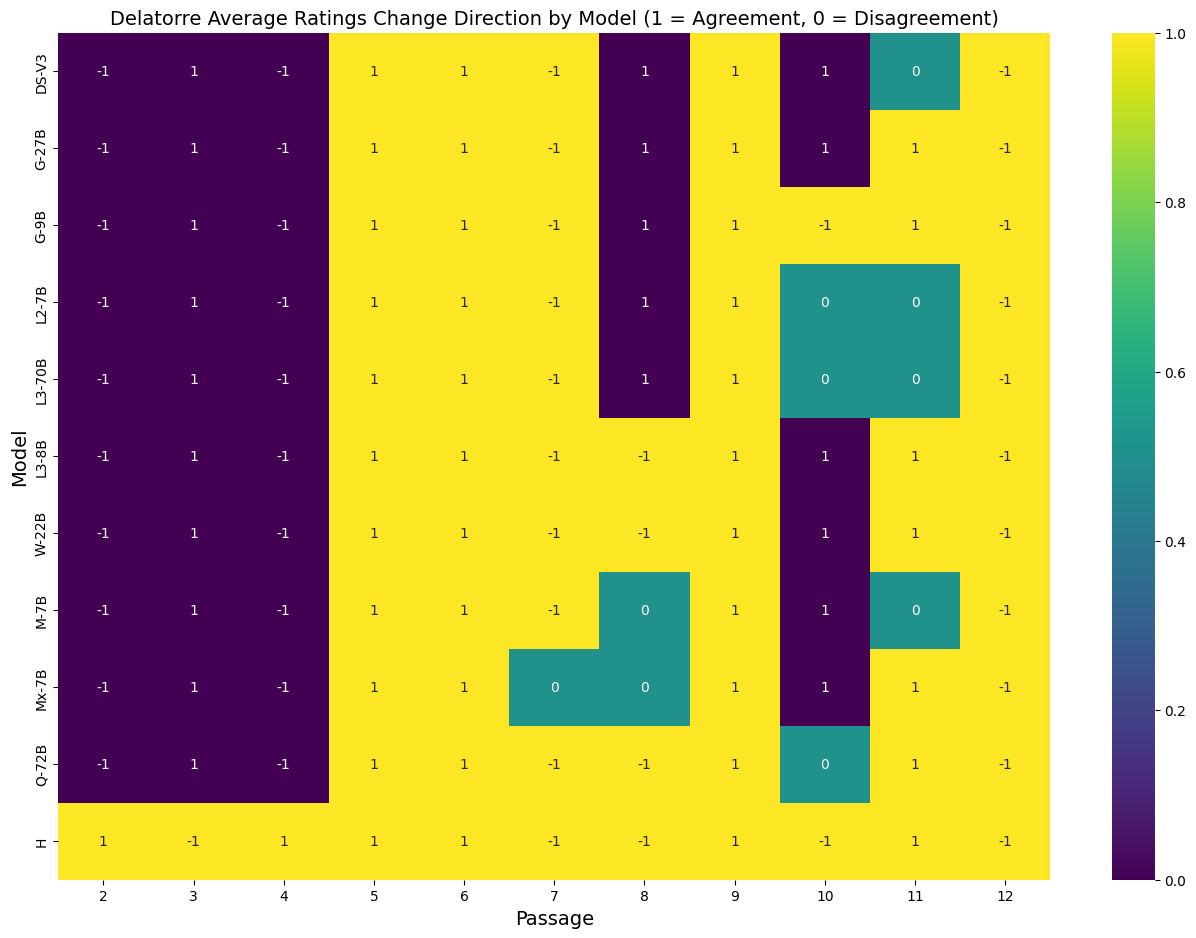

In [133]:
model_names = list(llm_ratings_by_model.keys()) + ["H"]
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

llm_ratings_change_direction = np.where(llm_ratings_change > 0, 1, np.where(llm_ratings_change < 0, -1, llm_ratings_change))
human_ratings_change_direction = np.where(human_ratings_change > 0, 1, np.where(human_ratings_change < 0, -1, human_ratings_change))

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change_direction - human_ratings_change_direction))
agreement_matrix = 1 - (np.abs(llm_ratings_change_direction - human_ratings_change_direction) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=llm_ratings_change_direction, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(2, llm_ratings_change_direction.shape[1] + 2), yticklabels=model_names)

plt.title(f"{target} Average Ratings Change Direction by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Model", fontsize=fontsize)
plt.show()

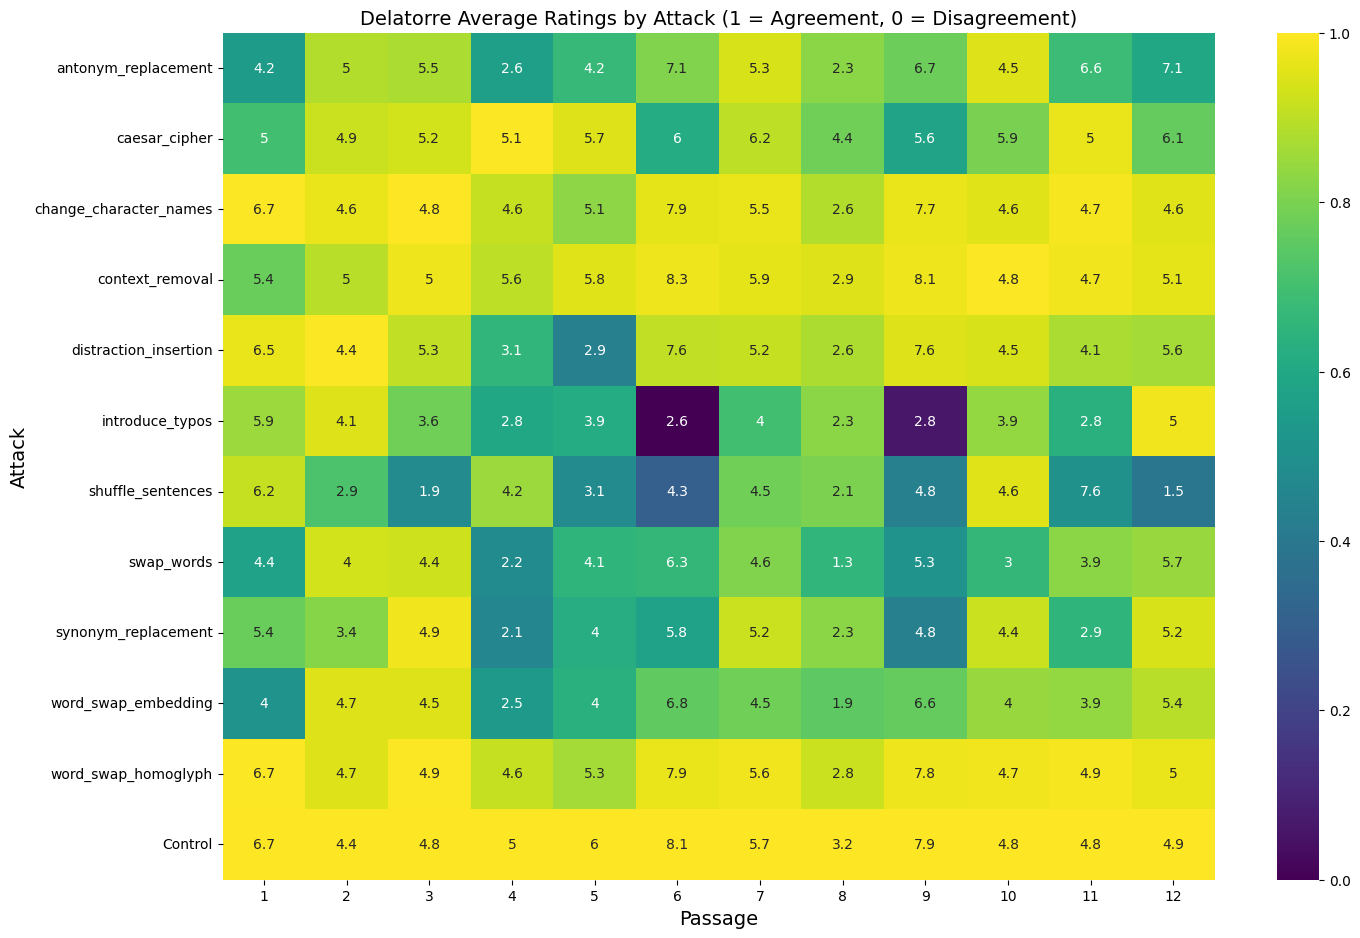

In [134]:
control_ratings = llm_ratings_adversarial["control"]
llm_ratings_adversarial.pop("control")

attack_names = list(llm_ratings_adversarial.keys()) + ["Control"]
llm_ratings = np.array(list(llm_ratings_adversarial.values()) + [control_ratings])

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings - control_ratings))
agreement_matrix = 1 - (np.abs(llm_ratings - control_ratings) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="viridis", cbar=True, linewidths=0, xticklabels=range(1, llm_ratings.shape[1] + 1), yticklabels=attack_names)

plt.title(f"{target} Average Ratings by Attack (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Attack", fontsize=fontsize)
plt.show()